In [22]:
import os 
os.listdir('/kaggle/input') 

embeddings_path = "/kaggle/input/embeddings"
print(os.listdir(embeddings_path))
import pandas as pd

speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_with_embeddings.csv")
news_embeddings = pd.read_csv(f"{embeddings_path}/news_with_embeddings.csv")

# Display first few rows
print("News Data:")
print(news_embeddings.head())

print("\nSpeeches Data:")
print(speeches_embeddings.head())

['speeches_with_embeddings.csv', 'speeches_embeddings_sentiment.csv', 'news_embeddings_sentiment.csv', 'news_with_embeddings.csv']
News Data:
          Index                                               Link  \
0  1_01_12_2018  https://www.bbc.com/mundo/noticias-america-lat...   
1  2_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
2  3_01_12_2018  https://oem.com.mx/elsoldemexico/mexico/en-don...   
3  4_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
4  5_01_12_2018  https://www.eleconomista.com.mx/politica/Nicol...   

                                              Domain  \
0  BBC\nToma de protesta de AMLO: las 5 tradicion...   
1  Expansión Política\nAMLO rinde protesta y prom...   
2  El Sol de México\n¿Hay Ley Seca este 1 de dici...   
3  Expansión Política\nAMLO es un "líder persiste...   
4  El Economista\nNicolás Maduro llega a Palacio ...   

                                               Title        Date  \
0  Toma de protesta de AMLO: las

In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

# Convert and verify date columns
news_embeddings['news_date'] = pd.to_datetime(news_embeddings['Date'])
speeches_embeddings['speech_date'] = pd.to_datetime(speeches_embeddings['date'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#Temporal window calculation and expansion
def generate_temporal_pairs(news_df, speeches_df, window_days=3):
    """Generate news-speech pairs within a symmetric temporal window (-3 to +3 days)"""
    pairs = []
    chunk_size = 2000
    news_chunks = np.array_split(news_df, len(news_df) // chunk_size + 1)
    
    for chunk in news_chunks:
        for _, row in chunk.iterrows():
            news_date = row['news_date']
            start_date = news_date - pd.Timedelta(days=window_days) 
            end_date = news_date + pd.Timedelta(days=window_days)  
            
            mask = (speeches_df['speech_date'] >= start_date) & (speeches_df['speech_date'] <= end_date)
            speech_ids = speeches_df[mask].index.tolist()
            pairs.extend([(row.name, s_id) for s_id in speech_ids])
    
    return pd.DataFrame(pairs, columns=['news_id', 'speech_id'])


alignment_df = generate_temporal_pairs(news_embeddings, speeches_embeddings)

#optimized embeddings calculation
def load_embeddings_half(df, col_name):
    embeddings = []
    for i, row in df.iterrows():
        if isinstance(row[col_name], str):
            arr = np.fromstring(row[col_name].strip("[]"), sep=" ", dtype=np.float16)
        else:
            arr = np.array(row[col_name], dtype=np.float16)
        embeddings.append(torch.tensor(arr, device=device).half())
        if i % 1000 == 0: torch.cuda.empty_cache()
    return torch.stack(embeddings)

news_tensor = load_embeddings_half(news_embeddings, 'news_embeddings')
speeches_tensor = load_embeddings_half(speeches_embeddings, 'speech_embeddings')

#Batched cosine similarity computation
def compute_cosine_similarities(pairs_df, news_emb, speech_emb, batch_size=8192):
    news_norm = F.normalize(news_emb, p=2, dim=1)
    speech_norm = F.normalize(speech_emb, p=2, dim=1)
    similarities = []
    for i in range(0, len(pairs_df), batch_size):
        batch = pairs_df.iloc[i:i+batch_size]
        news_batch = news_norm[batch['news_id'].values]
        speech_batch = speech_norm[batch['speech_id'].values]
        similarities.append(F.cosine_similarity(news_batch, speech_batch).cpu().numpy())
        del news_batch, speech_batch
        torch.cuda.empty_cache()
    return np.concatenate(similarities)

alignment_df['cosine_similarity'] = compute_cosine_similarities(alignment_df, news_tensor, speeches_tensor)

#include metadata to the embeddings to track temporal dependencies
def add_temporal_features(pairs_df, news_df, speeches_df):
    pairs_df = pairs_df.merge(
        news_df[['news_date']],
        left_on='news_id',
        right_index=True
    ).merge(
        speeches_df[['speech_date']],
        left_on='speech_id',
        right_index=True
    )
    pairs_df['days_diff'] = (pairs_df['news_date'] - pairs_df['speech_date']).dt.days
    return pairs_df

enriched_df = add_temporal_features(alignment_df, news_embeddings, speeches_embeddings)

#Save data to avoid rerunning everything again 
enriched_df.to_parquet('news_speech_similarities.parquet', engine='pyarrow', compression='zstd')
print("Processing complete. Results saved with columns:", enriched_df.columns.tolist())

Using device: cuda


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Processing complete. Results saved with columns: ['news_id', 'speech_id', 'cosine_similarity', 'news_date', 'speech_date', 'days_diff']


In [24]:
def load_safe_data():
    """Load data with proper dtype conversions"""
    df = pd.read_parquet('news_speech_similarities.parquet').astype({
        'news_id': 'int64',
        'speech_id': 'int64',
        'cosine_similarity': 'float32'  # Convert from float16 to float32
    })
    df['news_date'] = pd.to_datetime(df['news_date'])
    return df

# Load processed data
df = load_safe_data()

# Load processed data
df = pd.read_parquet('news_speech_similarities.parquet') #We can use this code when we compute everything again, else we have to roead the parquet
#df = pd.read_parquet(SIMILARITIES_PATH) #Piece of code when we have the path defined, otherwise it'll work by loading them again. 
# Convert to datetime and normalize (remove time components)
df['news_date'] = pd.to_datetime(df['news_date']).dt.normalize()
df['year'] = df['news_date'].dt.year

# Create daily aggregates with std dev
daily_agg = df.groupby('news_date')['cosine_similarity'].agg(['mean', 'std']).reset_index()
daily_agg.columns = ['date', 'cosine_similarity', 'std_dev']

# Extend full_dates to include October 2024 explicitly
end_date = pd.to_datetime('2024-10-31')  # Adjust as needed
full_dates = pd.date_range(
    start=daily_agg['date'].min(), 
    end=end_date, 
    freq='D'
)
daily_agg = daily_agg.set_index('date').reindex(full_dates).reset_index().rename(columns={'index': 'date'})

# Calculate bounds
daily_agg['upper_bound'] = daily_agg['cosine_similarity'] + daily_agg['std_dev'].fillna(0)
daily_agg['lower_bound'] = daily_agg['cosine_similarity'] - daily_agg['std_dev'].fillna(0)

# Create monthly aggregates (fill NaN with 0 for plotting)
monthly_agg = daily_agg.set_index('date').resample('M')['cosine_similarity'].mean().fillna(0).reset_index()
monthly_agg['month_label'] = monthly_agg['date'].dt.strftime('%b\n%Y')

# Get unique years present in data
years = daily_agg['date'].dt.year.unique()

<ipython-input-24-fd48d6189ee0>:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_agg = daily_agg.set_index('date').resample('M')['cosine_similarity'].mean().fillna(0).reset_index()


In [28]:
import os
import re
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from urllib.parse import urlparse
from sklearn.preprocessing import OneHotEncoder

# Configuration
EMBEDDINGS_PATH = "/kaggle/input/embeddings"
OUTLET_CACHE = "outlet_cache.parquet"
SIMILARITIES_PATH = "news_speech_similarities.parquet"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
import pandas as pd
from pathlib import Path
import statsmodels.formula.api as smf
import re

# Configuration
OUTLET_CACHE_PATH = 'outlet_cache.parquet'

def extract_and_cache_outlets(news_df, force_refresh=False):
    """Properly index-aligned outlet extraction with validation"""
    if not force_refresh and Path(OUTLET_CACHE_PATH).exists():
        outlets = pd.read_parquet(OUTLET_CACHE_PATH)
        return outlets.set_index('news_id')['outlet']

    print("Extracting outlets with index preservation...")
    pattern = r"https?://(?:www\.)?([^/.]+)\."
    
    # Preserve original news_id index
    outlets = (
        news_df.reset_index()[['index', 'Link']]
        .rename(columns={'index': 'news_id'})
        .assign(
            outlet=lambda x: x['Link']
                .str.extract(pattern, flags=re.IGNORECASE)[0]
                .str.lower()
                .fillna('unknown')
        )
        [['news_id', 'outlet']]
        .set_index('news_id')
    )
    
    outlets.to_parquet(OUTLET_CACHE_PATH)
    return outlets['outlet']

def prepare_regression_data(enriched_df, news_embeddings):
    """Prepare data with top 10 outlets and temporal features"""
    # 1. Merge outlet data
    if 'outlet' not in enriched_df.columns:
        outlets = extract_and_cache_outlets(news_embeddings)
        
        # Perform merge with validation
        enriched_df = pd.merge(
            enriched_df,
            outlets.to_frame(),
            left_on='news_id',
            right_index=True,
            how='left',
            validate='m:1'
        )
        enriched_df['outlet'] = enriched_df['outlet'].fillna('unknown')

    # 2. Filter to top 10 outlets + "other" category
    top_outlets = enriched_df['outlet'].value_counts().nlargest(10).index.tolist()
    enriched_df['outlet_top10'] = enriched_df['outlet'].where(
        enriched_df['outlet'].isin(top_outlets),
        'other'
    )
    
    # 3. Add temporal features
    enriched_df = enriched_df.assign(
        year=lambda x: pd.to_datetime(x['news_date']).dt.year.astype('int16'),
        month=lambda x: pd.to_datetime(x['news_date']).dt.month.astype('int8')
    )
    
    # 4. Optimize data types
    return enriched_df.astype({
        'days_diff': 'int16',
        'cosine_similarity': 'float32',
        'outlet_top10': 'category'
    }).drop(columns=['outlet']) #here there is a place to drop "news_date" column to save memory 

# Regression execution
if __name__ == "__main__":
    # Force cache refresh
    Path(OUTLET_CACHE_PATH).unlink(missing_ok=True)
    
    # Load and prepare data
    enriched_df = pd.read_parquet('news_speech_similarities.parquet')
    enriched_df = prepare_regression_data(enriched_df, news_embeddings)
    
    # Verify and run regressions
    assert 'outlet_top10' in enriched_df.columns, "Top10 outlet column missing!"
    
    # 1. Temporal Effects Model
    print("\n" + "="*50)
    print("TEMPORAL EFFECTS REGRESSION (with Top10 Outlets)")
    print("="*50)
    print(smf.ols('cosine_similarity ~ days_diff + C(year) + C(month) + C(outlet_top10)', 
                data=enriched_df).fit(cov_type='HC3').summary())
    
    # 2. Outlet Fixed Effects (Top10 only)
    print("\n" + "="*50)
    print("TOP10 OUTLET FIXED EFFECTS REGRESSION")
    print("="*50)
    print(smf.ols('cosine_similarity ~ C(outlet_top10)', 
                data=enriched_df).fit(cov_type='HC3').summary())
    
    # 3. Simple Model
    print("\n" + "="*50)
    print("SIMPLE TEMPORAL PROXIMITY")
    print("="*50)
    print(smf.ols('cosine_similarity ~ days_diff', 
                data=enriched_df).fit(cov_type='HC3').summary())

Extracting outlets with index preservation...

TEMPORAL EFFECTS REGRESSION (with Top10 Outlets)
                            OLS Regression Results                            
Dep. Variable:      cosine_similarity   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                 1.316e+05
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:29:25   Log-Likelihood:             2.8382e+07
No. Observations:            24418171   AIC:                        -5.676e+07
Df Residuals:                24418142   BIC:                        -5.676e+07
Df Model:                          28                                         
Covariance Type:                  HC3                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
--------------

In [32]:
print(enriched_df.head())

   news_id  speech_id  cosine_similarity  news_date speech_date  days_diff  \
0        0     150494            0.31543 2018-12-01  2018-12-04         -3   
1        0     150495            0.31543 2018-12-01  2018-12-04         -3   
2        0     150496            0.31543 2018-12-01  2018-12-04         -3   
3        0     150497            0.31543 2018-12-01  2018-12-04         -3   
4        0     150498            0.31543 2018-12-01  2018-12-04         -3   

  outlet_top10  year  month  
0        other  2018     12  
1        other  2018     12  
2        other  2018     12  
3        other  2018     12  
4        other  2018     12  


In [33]:
!pip install pmdarima

In [ ]:
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

def prepare_regression_data(enriched_df, news_embeddings):
    """Prepare data with proper temporal column handling"""
    # 1. Merge outlet data
    if 'outlet' not in enriched_df.columns:
        outlets = extract_and_cache_outlets(news_embeddings)
        enriched_df = pd.merge(
            enriched_df,
            outlets.to_frame(),
            left_on='news_id',
            right_index=True,
            how='left',
            validate='m:1'
        )
        enriched_df['outlet'] = enriched_df['outlet'].fillna('unknown')

    # 2. Filter to top 10 outlets
    top_outlets = enriched_df['outlet'].value_counts().nlargest(10).index.tolist()
    enriched_df['outlet_top10'] = enriched_df['outlet'].where(
        enriched_df['outlet'].isin(top_outlets),
        'other'
    ).astype('category')

    # 3. Verify and convert temporal columns
    if 'news_date' not in enriched_df.columns:
        raise KeyError("news_date column missing in input data")
    
    enriched_df = enriched_df.assign(
        news_date=lambda x: pd.to_datetime(x['news_date']),
        year=lambda x: x.news_date.dt.year.astype('int16'),
        month=lambda x: x.news_date.dt.month.astype('int8')
    )

    # 4. Optimize data types
    return enriched_df.astype({
        'days_diff': 'int16',
        'cosine_similarity': 'float32'
    }).drop(columns=['outlet'])  # Keep news_date


# First validate columns
print("Available columns:", enriched_df.columns.tolist())

# Prepare time series data with validation
if 'news_date' not in enriched_df.columns:
    raise KeyError("news_date column not found - check data preparation")

ts_data = (
    enriched_df
    .groupby('news_date', observed=True)
    ['cosine_similarity']
    .mean()
    .asfreq('D')  # Ensure daily frequency
    .fillna(method='ffill')
)

# Stationarity check and modeling
print("\nStationarity check (ADF p-value):", adfuller(ts_data)[1])

arima_model = auto_arima(
    ts_data,
    seasonal=True,
    m=7,
    trace=True,
    suppress_warnings=True,
    error_action='ignore',
    stepwise=True
)

print("\nARIMA Model Summary:")
print(arima_model.summary())


# Forecast validation
train = ts_data[:int(0.8*len(ts_data))]
test = ts_data[int(0.8*len(ts_data)):]
arima_model.fit(train)
forecast = arima_model.predict(n_periods=len(test))
print(f"MSE: {mean_squared_error(test, forecast)}")
# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, forecast, label='Forecast', alpha=0.7)
plt.fill_between(test.index, 
                 forecast - 1.96*np.std(forecast), 
                 forecast + 1.96*np.std(forecast), 
                 alpha=0.2)
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()

Available columns: ['news_id', 'speech_id', 'cosine_similarity', 'news_date', 'speech_date', 'days_diff', 'outlet_top10', 'year', 'month']


<ipython-input-37-82a4412c4f09>:54: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  enriched_df



Stationarity check (ADF p-value): 3.454750679452771e-06
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=-8145.483, Time=4.70 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-7184.828, Time=0.21 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-7692.059, Time=0.70 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-8104.559, Time=1.83 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-7186.827, Time=0.11 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=-8152.345, Time=4.97 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=-8154.373, Time=3.64 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=-8145.825, Time=3.53 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=-8138.963, Time=2.21 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=-8188.997, Time=2.09 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=-8173.117, Time=3.48 sec
 ARIMA(2,1,1)(0,0,1)[7] intercept   : AIC=-8162.458, Time=3.21 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=-8141.492, Time=3.86 sec
 ARIMA(1,1,1)(0,0,0)[7] inter

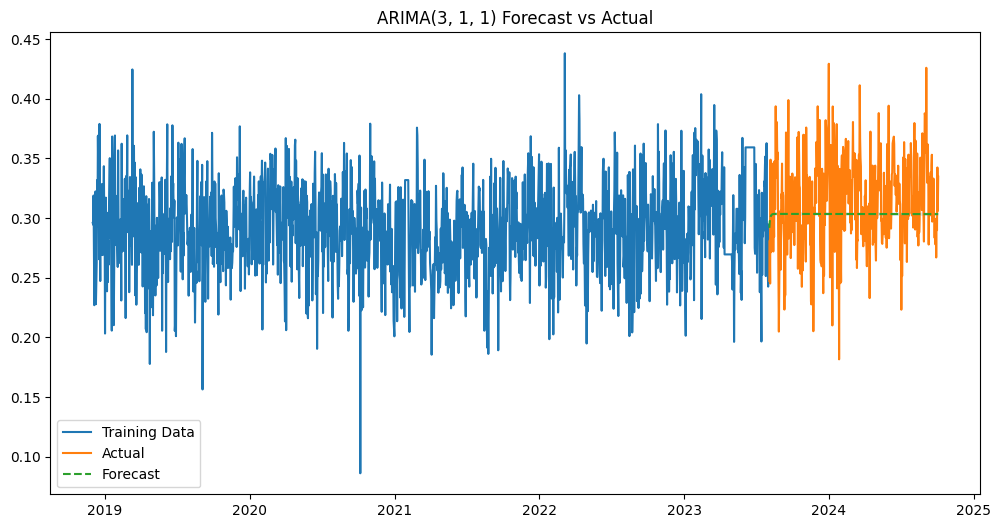

MSE: 0.0015


In [40]:
# Forecast validation
train_size = int(0.8 * len(ts_data))
train, test = ts_data[:train_size], ts_data[train_size:]
forecast = arima_model.predict(n_periods=len(test))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.fill_between(
    test.index,
    forecast - 1.96*np.std(forecast),
    forecast + 1.96*np.std(forecast),
    alpha=0.2
)
plt.title(f"ARIMA{arima_model.order} Forecast vs Actual")
plt.legend()
plt.show()

print(f"MSE: {mean_squared_error(test, forecast):.4f}")